# Introduction
## Load libs

In [54]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# plot model
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

## Settings

In [18]:
TRAIN_PATH = "../input/sentiment140/training.1600000.processed.noemoticon.csv"
TEST_PATH = "./data/testdata.manual.2009.06.14.csv"
COLNAMES = ["polarity", "id", "date", "query", "user", "text"]

TRAIN_SIZE = 0.8

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

## Load data


In [19]:
train_df = pd.read_csv(TRAIN_PATH, encoding = 'ISO-8859-1', header = None)
train_df.columns = COLNAMES

The data is a CSV with emoticons removed. Data file format has 6 fields:
- polarity - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- id - the id of the tweet (2087)
- date - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- query - the query (lyx). If there is no query, then this value is NO_QUERY.
- user - the user that tweeted (robotickilldozr)
- text - the text of the tweet (Lyx is cool)

In [20]:
decode_map = {0: "NEGATIVE", 2:"NEUTRAL", 4:"POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

decode polarity number code


In [21]:
%%time
train_df.polarity = train_df.polarity.apply(lambda x: decode_sentiment(x))

CPU times: user 660 ms, sys: 0 ns, total: 660 ms
Wall time: 662 ms


Text(0.5, 1.0, 'Polatiry distribution')

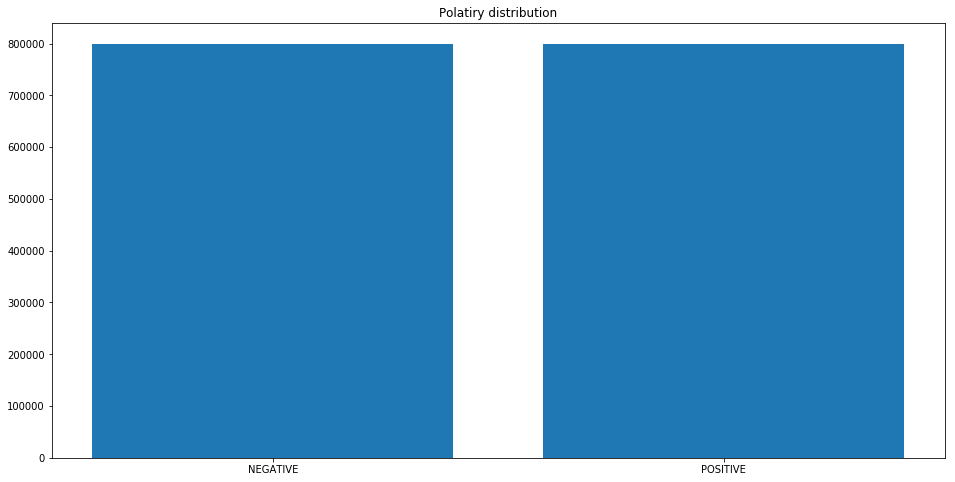

In [22]:
# plot polarity distribution
polarity_cnt = Counter(train_df.polarity)

plt.figure(figsize = (16,8))
plt.bar(polarity_cnt.keys(), polarity_cnt.values())
plt.title("Polatiry distribution")

# Pre-porcess data

In [23]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

# remove links, users, special characters
def prepocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, " ", str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [24]:
%%time
train_df.text = train_df.text.apply(lambda x: prepocess(x))

CPU times: user 58.2 s, sys: 168 ms, total: 58.3 s
Wall time: 58.4 s


Train Test Split

In [25]:
train_df, test_df = train_test_split(train_df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(train_df))
print("TEST size:", len(test_df))

TRAIN size: 1280000
TEST size: 320000


# Word2Vec

split text to words

In [28]:
%%time
documents = [_text.split() for _text in train_df.text]

CPU times: user 3.57 s, sys: 232 ms, total: 3.8 s
Wall time: 3.85 s


In [29]:
# create w2v model
w2v_model = gensim.models.word2vec.Word2Vec(size = W2V_SIZE,
                                           window = W2V_WINDOW,
                                           min_count= W2V_MIN_COUNT,
                                           workers = 4)

In [30]:
# generate vacabulary
w2v_model.build_vocab(documents)

In [31]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print(f"Vocab size: {vocab_size}")

Vocab size: 30369


In [32]:
%%time
w2v_model.train(documents, total_examples = len(documents), epochs=W2V_EPOCH)

CPU times: user 20min 7s, sys: 6.27 s, total: 20min 13s
Wall time: 10min 38s


(263122522, 295270528)

In [33]:
# test w2v
w2v_model.most_similar("fun")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('funn', 0.5003114938735962),
 ('blast', 0.4943140149116516),
 ('great', 0.4289982318878174),
 ('awesome', 0.4229722023010254),
 ('funnn', 0.3988300859928131),
 ('miss', 0.37662315368652344),
 ('enjoy', 0.3751881718635559),
 ('funnnn', 0.37500661611557007),
 ('enjoyed', 0.37075376510620117),
 ('enjoyable', 0.35742902755737305)]

# Tokenize text

In [34]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.text)

vocab_size = len(tokenizer.word_index) + 1
print(f"Total words: {vocab_size}")

Total words: 290419
CPU times: user 22.5 s, sys: 124 ms, total: 22.6 s
Wall time: 22.6 s


**pad_sequences:**
`This function transforms a list of num_samples sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.`

In [39]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 33.4 s, sys: 956 ms, total: 34.3 s
Wall time: 34.4 s


# Label Encoder

In [40]:
labels = train_df.polarity.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [41]:
encoder = LabelEncoder()
encoder.fit(train_df.polarity.tolist())

y_train = encoder.transform(train_df.polarity.tolist())
y_test = encoder.transform(test_df.polarity.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [42]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


# Build model
## Embedding

In [43]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [44]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights = [embedding_matrix], input_length=SEQUENCE_LENGTH, trainable = False)

## Model

In [45]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [46]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])



callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [55]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train

In [56]:
%%time
history = model.fit(x_train, y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_split = 0.1,
                   verbose = 1,
                   callbacks = callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 547s 474us/step - loss: 0.4930 - acc: 0.7582 - val_loss: 0.4637 - val_acc: 0.7791
Epoch 2/8
1152000/1152000 [==============================] - 550s 477us/step - loss: 0.4775 - acc: 0.7681 - val_loss: 0.4566 - val_acc: 0.7838
Epoch 3/8
1152000/1152000 [==============================] - 559s 486us/step - loss: 0.4718 - acc: 0.7720 - val_loss: 0.4536 - val_acc: 0.7856
Epoch 4/8
1152000/1152000 [==============================] - 550s 477us/step - loss: 0.4705 - acc: 0.7731 - val_loss: 0.4551 - val_acc: 0.7837
Epoch 5/8
1152000/1152000 [==============================] - 545s 473us/step - loss: 0.4692 - acc: 0.7742 - val_loss: 0.4504 - val_acc: 0.7887
Epoch 6/8
1152000/1152000 [==============================] - 541s 469us/step - loss: 0.4659 - acc: 0.7762 - val_loss: 0.4493 - val_acc: 0.7882
Epoch 7/8
1152000/1152000 [==============================] - 539s 468us/step - loss: 0.46

## Evaluate

In [57]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY: ", score[1])
print("LOSS: ", score[0])

320000/320000 [==============================] - 58s 180us/step

ACCURACY:  0.790134375
LOSS:  0.4497887333393097


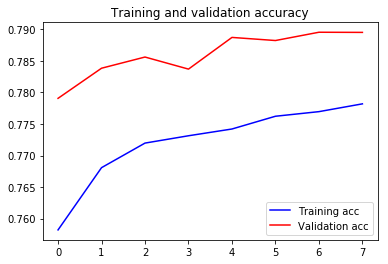

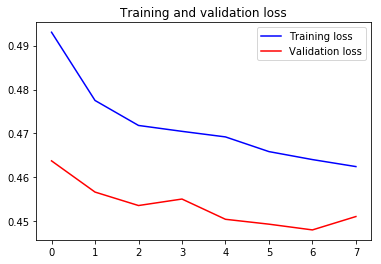

In [58]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Predict

In [59]:
def decode_sentiment(score, include_neutral = True):
    if include_neutralude_neutralude_neutralude_neutral:
  score   lSENTIMENT_THRESHOLDSl = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
            
        return label
    else:
        return NEGATIVE if score <0.5 else POSITIVE

In [60]:
def predict(text, include_neutral = True):
    start_at = time.time()
    # tokenize
    x_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = SEQUENCE_LENGTH)
    # predict
    score = model.predict([x_text])[0]
    # decode
    labeinclude_neutral=utral=_sentiment(score, include_neutral = include_neutral)
    
    return {"label":label, "score": float(score), "elapsed_time": time.time() - start_at}

In [61]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9735809564590454,
 'elapsed_time': 0.34731388092041016}

## Confusion Matrix

In [64]:
%%time
y_pred_1d = []
y_test_1d = list(test_df.polarity)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 20s 64us/step
CPU times: user 12.3 s, sys: 1.66 s, total: 14 s
Wall time: 21 s


In [65]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


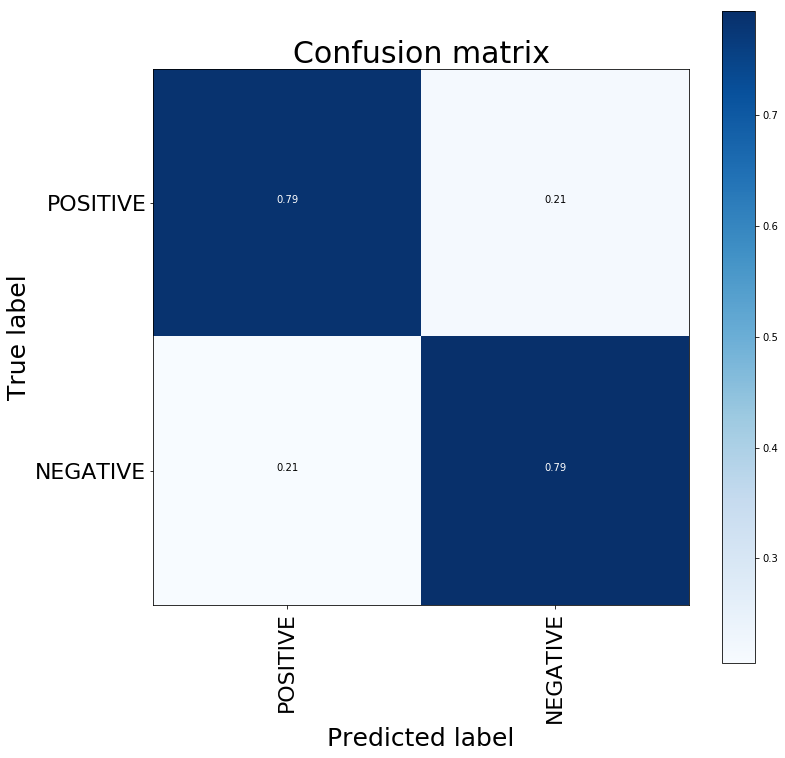

CPU times: user 1.09 s, sys: 244 ms, total: 1.33 s
Wall time: 1.12 s


In [67]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=train_df.polarity.unique(), title="Confusion matrix")
plt.show()


# Report

In [68]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.79      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



# Save models

In [69]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

# Links
1. https://medium.com/@himanshu_23732/sentiment-analysis-with-sentiment140-e6b0c789e0ce
1. https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis
1. https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis
1. https://keras.io/